In [143]:
# Imports
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Reshape
from tensorflow.keras.models import Sequential

In [144]:
# Don't run this block of code if you aren't using Tensorflow-GPU.
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices------------- 1


In [145]:
def normalize(values):
    """This function takes as input a set of values and outputs the normalized values, their mean and their standard
    deviation.

    :param values: Integer or float values that we want to normalize.
    :returns values: Normalized values.
             mean: Mean of the values.
             std: Standard deviation of the values."""

    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std

    return values, mean, std

In [146]:
def create_sequences(values, time_steps):
    """This function takes as input a set of values and outputs the values in a time-series format.

    :param values: Integer or float values that we want to convert to time-series format.
    :param time_steps: Integer indicating the length of the time-series.
    :return output: An array of time-series values."""

    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i: (i + time_steps)])

    return np.expand_dims(output, axis=2)

In [147]:
def get_anomaly_indices(threshold, train_loss):
    """This function returns the indices of the anomalies.
    :param threshold: Integer or float indicating the threshold we above which we would consider data points to be
                      anomalies.
    :param train_loss: The training loss.
    :return: indices: The indices of the anomalies."""

    anomalies = (train_loss > threshold).tolist()
    flat_list = []
    for sublist in anomalies:
        for item in sublist:
            flat_list.append(item)
    anomaly_indices = [i for i, x in enumerate(flat_list) if x == True]

    return anomaly_indices

In [148]:
import matplotlib.pyplot as plt
import pandas as pd

def compare(dataset, anomaly_indices):
    """This function plots the comparison of the anomalies with the original dataset.

    :param dataset: The dataset on which we want to make a comparison.
    :param anomaly_indices: The indices of the anomalies in the dataset.
    """
    # Extraire les anomalies à partir des indices
    anomalies = dataset.iloc[anomaly_indices]

    # Créer une copie du dataset avec les valeurs à None (pour mettre en évidence les anomalies)
    dataset_copy = dataset.copy()
    dataset_copy['value'] = None

    # Fusionner pour garder uniquement les valeurs des anomalies
    combine = anomalies.combine_first(dataset_copy)

    # Récupérer les timestamps et valeurs du dataset d'origine
    dates_full = dataset["timestamp"].tolist()
    values_full = dataset["value"].tolist()

    # Récupérer les timestamps et valeurs des anomalies
    dates_anom = combine["timestamp"].tolist()
    values_anom = combine["value"].tolist()

    # Tracer
    plt.figure(figsize=(15, 7))
    plt.plot(dates_full, values_full, label="Test data", color="blue")
    plt.plot(dates_anom, values_anom, label="Anomalies", color="red")
    plt.xlabel("Timestamp")
    plt.ylabel("Value")
    plt.title("Anomaly Detection Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()


In [149]:
def dense(x__train):
    """This function creates the Dense auto-encoder model.

    :param x__train: The training data. It is used to set the input shape.
    :return autoencoder: The autoencoder model."""

    inputs = Input(shape=(x__train.shape[1], x__train.shape[2]))

    # Encoding
    x = Flatten()(inputs)
    x = Dense(32, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    encoded = Dense(128, activation='relu')(x)

    # Decoding
    x = Dense(128, activation='relu')(encoded)
    x = Dense(64, activation='relu')(x)
    x = Dense(32)(x)
    decoded = Reshape((32, 1))(x)

    autoencoder = Model(inputs, decoded)

    return autoencoder

In [150]:
cpu_utilization = pd.read_csv('/kaggle/input/nab/realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv')

# Statistics about the dataset.
print('\nCPU Utilization Dataset Shape:', cpu_utilization.shape)
print('\nFirst 5 rows of the CPU Utilization Dataset:\n', cpu_utilization.head())
print('\nCPU Utilization Dataset description:\n', cpu_utilization.describe())


CPU Utilization Dataset Shape: (4032, 2)

First 5 rows of the CPU Utilization Dataset:
              timestamp   value
0  2014-02-14 14:27:00  51.846
1  2014-02-14 14:32:00  44.508
2  2014-02-14 14:37:00  41.244
3  2014-02-14 14:42:00  48.568
4  2014-02-14 14:47:00  46.714

CPU Utilization Dataset description:
              value
count  4032.000000
mean     43.110372
std       4.303565
min      34.766000
25%      39.296000
50%      42.918000
75%      46.006000
max      68.092000


### Notice there are two obvious spikes, which means the cpu utilization reaches beyond 60%. This is the offical red line for Amazon. Therefore we should also detect the two peaks.

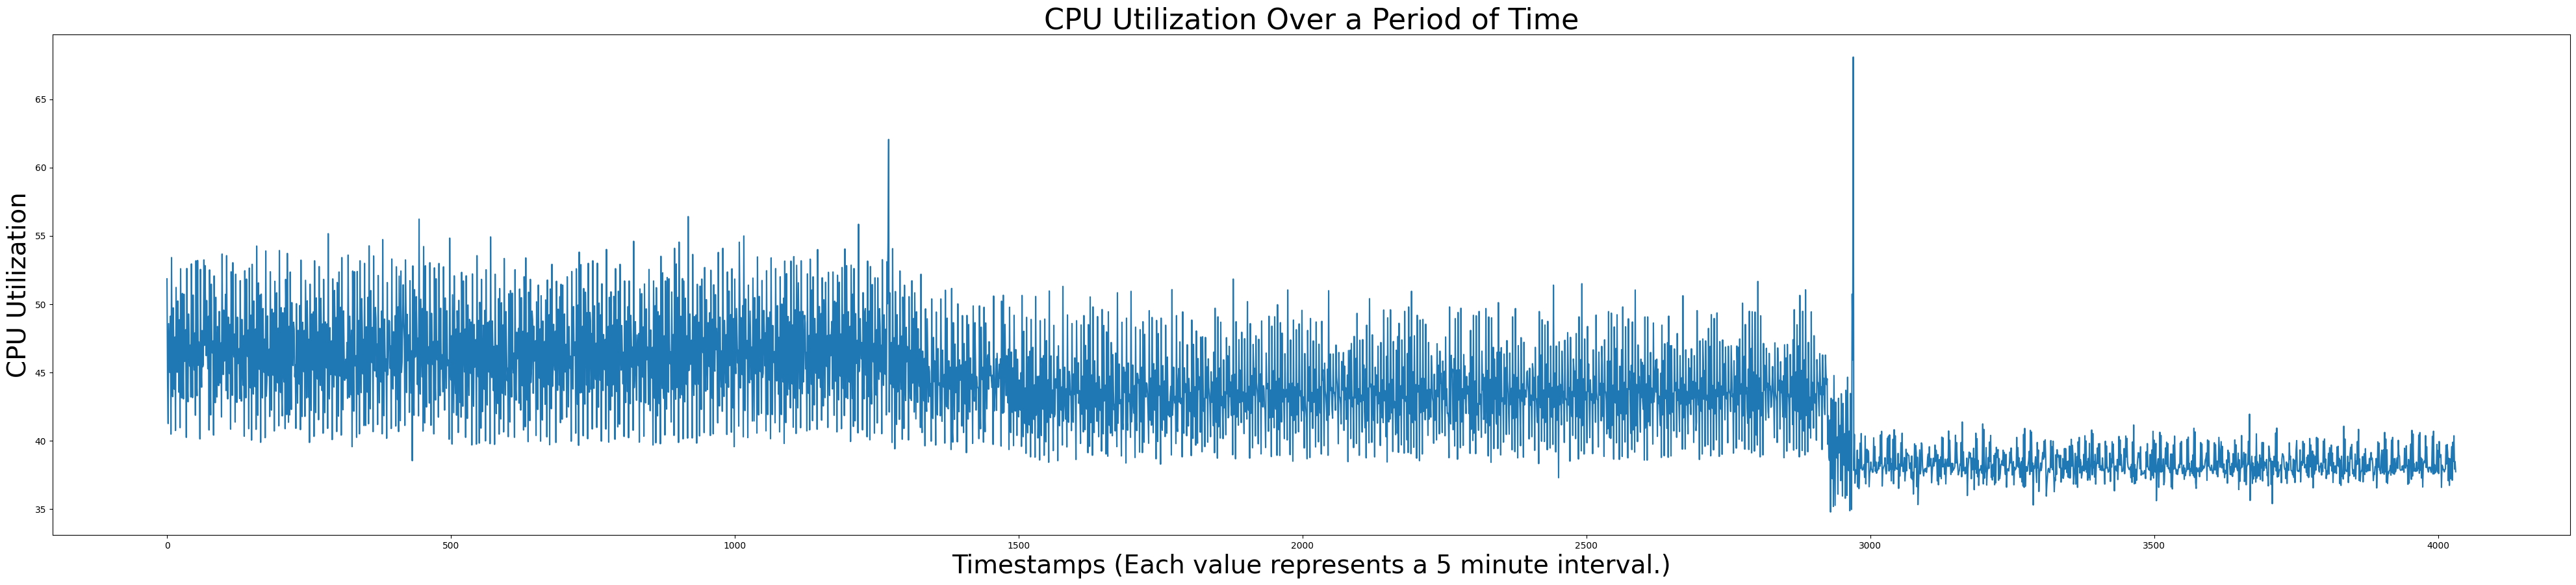

In [151]:
# Visualize the data.
plt.figure(figsize=(50, 10))
plt.plot(cpu_utilization['value'].values)
plt.xlabel('Timestamps (Each value represents a 5 minute interval.)', fontsize=28)
plt.ylabel('CPU Utilization', fontsize=28)
plt.title('CPU Utilization Over a Period of Time', fontsize=32)
plt.show()

In [152]:
cpu_utilization_values = cpu_utilization.value.to_list()


In [153]:
# print(cpu_utilization_values)

In [154]:
normalized_cpu_utilization_values, training_mean, training_std = normalize(cpu_utilization_values)

### Just like any other time series problems we also use timesteps or window.

In [155]:
x_train = create_sequences(normalized_cpu_utilization_values, time_steps=32)
print("Training data shape: ", x_train.shape)

Training data shape:  (4000, 32, 1)


## 1. Build a Autoencoder model for predicting a sequence of values.

### The following case is Conv1D model. 

In [156]:
# Conv1D based auto-encoder model.
model = keras.Sequential([layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
                          layers.Conv1D(filters=18, kernel_size=7, padding="same", strides=2, activation="relu"),
                          layers.Dropout(rate=0.2),
                          layers.Conv1D(filters=9, kernel_size=7, padding="same", strides=2, activation="relu"),
                          layers.Conv1DTranspose(filters=9, kernel_size=7, padding="same", strides=2,
                                                 activation="relu"),
                          layers.Dropout(rate=0.2),
                          layers.Conv1DTranspose(filters=18, kernel_size=7, padding="same", strides=2,
                                                 activation="relu"),
                          layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 16, 18)         │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 18)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 8, 9)           │         1,143 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_3              │ (None, 16, 9)          │           576 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_4              │ (None, 32, 18)         │         1,152 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_5              │ (None, 32, 1)          │           127 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,142 (12.27 KB)

 Trainable params: 3,142 (12.27 KB)

 Non-trainable params: 0 (0.00 B)

In [157]:
history = model.fit(x_train, x_train, epochs=50, batch_size=128, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")])

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.9218 - val_loss: 0.2256
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6783 - val_loss: 0.1808
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3398 - val_loss: 0.1523
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2443 - val_loss: 0.1246
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2100 - val_loss: 0.1022
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1847 - val_loss: 0.0825
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1779 - val_loss: 0.0717
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1581 - val_loss: 0.0611
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1457 - val_loss: 0.0484
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1367 - val_loss: 0.0480
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1308 - val_loss: 0.0407
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1192 - val_l

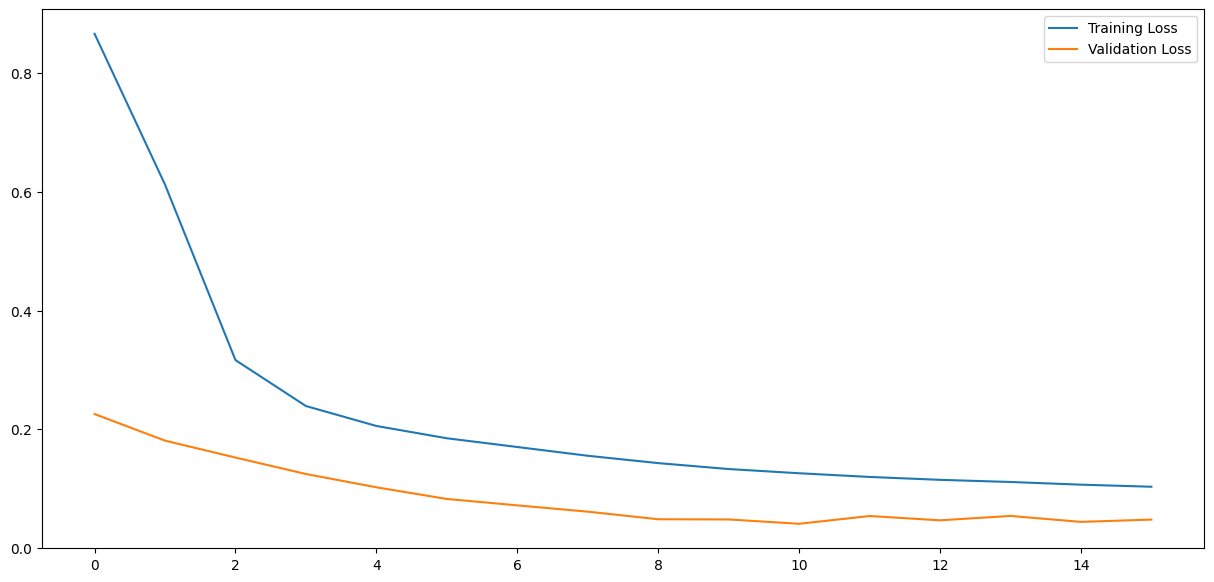

In [158]:
# Plotting the training and validation losses.
plt.figure(figsize=(15, 7))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

### From the MAE loss distribution below we can determine a good threshold, which can filter most of reasonable loss.

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


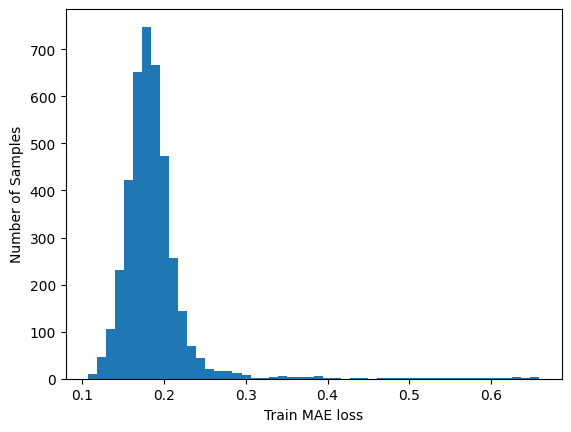

In [159]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("Number of Samples")
plt.show()

### We reconstruct the first window to see how well it works. 

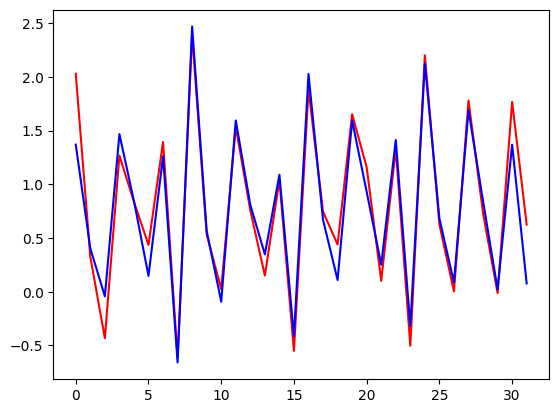

In [160]:
plt.plot(x_train[0],'red')
plt.plot(x_train_pred[0],'blue')
plt.show()

### Plotting the comparison of the dataset with the anomalies.

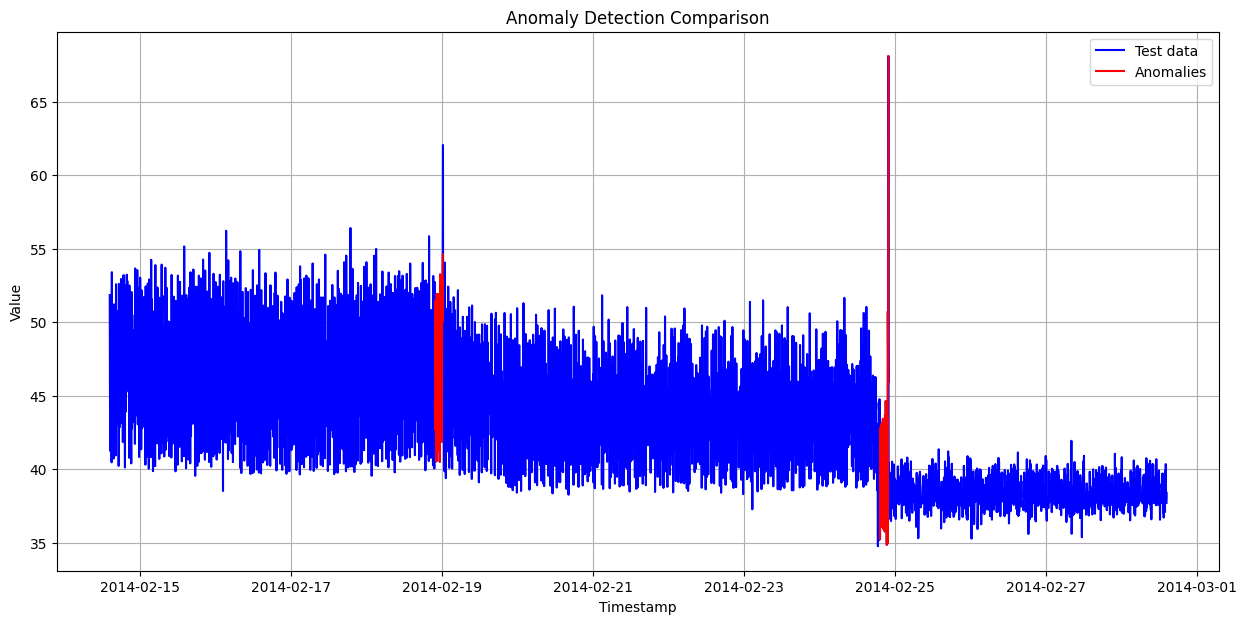

In [215]:
# Plotting the comparison of the dataset with the anomalies.
anomalies_index = get_anomaly_indices(threshold=0.3, train_loss=train_mae_loss)
compare(cpu_utilization, anomalies_index)

###  dense model.

In [162]:
model3 = dense(x_train)
model3.compile(optimizer='adam', loss='mae')
model3.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 32, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,336 (149.75 KB)

 Trainable params: 38,336 (149.75 KB)

 Non-trainable params: 0 (0.00 B)

In [163]:
history3 = model3.fit(x_train, x_train, epochs=70, batch_size=128, validation_split=0.1).history

Epoch 1/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.7106 - val_loss: 0.2958
Epoch 2/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4385 - val_loss: 0.1735
Epoch 3/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3404 - val_loss: 0.1677
Epoch 4/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2971 - val_loss: 0.1660
Epoch 5/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2717 - val_loss: 0.1653
Epoch 6/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2613 - val_loss: 0.1624
Epoch 7/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2461 - val_loss: 0.1576
Epoch 8/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2367 - val_loss: 0.1539
Epoch 9/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2287 - val_loss: 0.1474
Epoch 10/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2237 - val_loss: 0.1431
Epoch 11/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2186 - val_loss: 0.1422
Epoch 12/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2147 - val_l

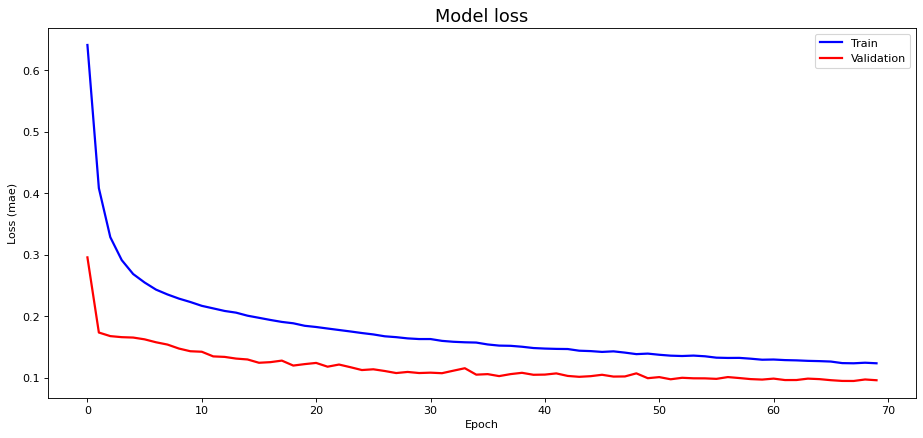

In [164]:
# Plotting the training and validation losses.
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history3['loss'], 'b', label='Train', linewidth=2)
ax.plot(history3['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


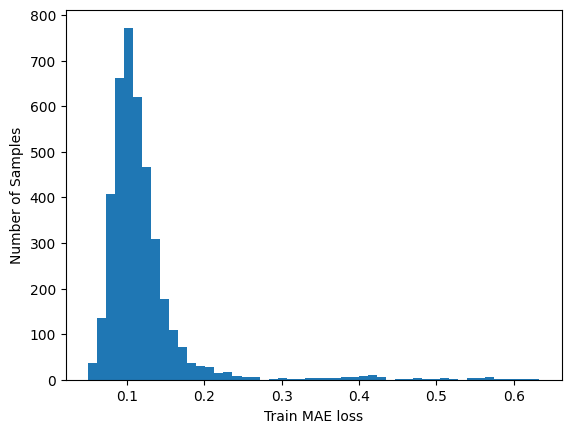

In [165]:
x_train_pred3 = model3.predict(x_train)
train_mae_loss3 = np.mean(np.abs(x_train_pred3 - x_train), axis=1)

plt.hist(train_mae_loss3, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("Number of Samples")
plt.show()

### We can see the dense mode works fairly well too.

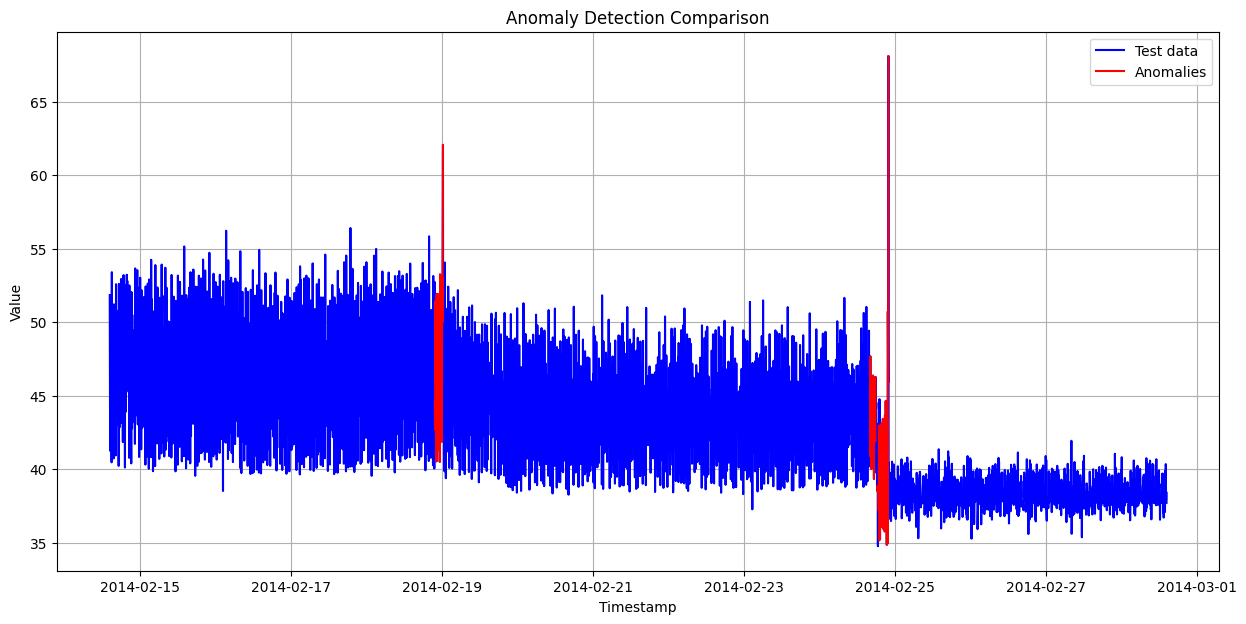

In [216]:
anomalies_index4 = get_anomaly_indices(threshold=0.25, train_loss=train_mae_loss3)
compare(cpu_utilization, anomalies_index4)

In [217]:
import json

with open("/kaggle/input/nab-combined-labels/combined_labels.json", 'r') as f: 
    labels = json.load(f)
anomalies = labels.get("realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv", [])
true_anomalies = [pd.to_datetime(t) for t in anomalies]
print("Anomalies annotées :", true_anomalies)

Anomalies annotées : [Timestamp('2014-02-19 00:22:00'), Timestamp('2014-02-24 18:37:00')]


In [218]:
cpu_utilization['timestamp'] = pd.to_datetime(cpu_utilization['timestamp'])


In [219]:
cpu_utilization['is-anomaly'] = cpu_utilization['timestamp'].apply(lambda t: 1 if t in true_anomalies else 0)

In [220]:
cpu_utilization.head()

,timestamp,value,is-anomaly
0,2014-02-14 14:27:00,51.846,0
1,2014-02-14 14:32:00,44.508,0
2,2014-02-14 14:37:00,41.244,0
3,2014-02-14 14:42:00,48.568,0
4,2014-02-14 14:47:00,46.714,0


In [221]:
cpu_utilization['is-anomaly'].value_counts()

is-anomaly
0    4030
1       2
Name: count, dtype: int64

In [222]:
true_labels = cpu_utilization['is-anomaly'].iloc[32:].reset_index(drop=True).values

In [223]:
sequence_timestamps = cpu_utilization['timestamp'].iloc[32:].reset_index(drop=True)


In [227]:
threshold =0.25
predicted_labels = (train_mae_loss3 > threshold).astype(int)



In [225]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

precision = precision_score(true_labels, predicted_labels, zero_division=0)
recall = recall_score(true_labels, predicted_labels, zero_division=0)
f1 = f1_score(true_labels, predicted_labels, zero_division=0)
auc = roc_auc_score(true_labels, train_mae_loss3)

print("🔹 Precision :", precision)
print("🔹 Recall    :", recall)
print("🔹 F1-score  :", f1)
print("🔹 AUC       :", auc)


🔹 Precision : 0.007692307692307693
🔹 Recall    : 0.5
🔹 F1-score  : 0.015151515151515154
🔹 AUC       : 0.9697348674337168


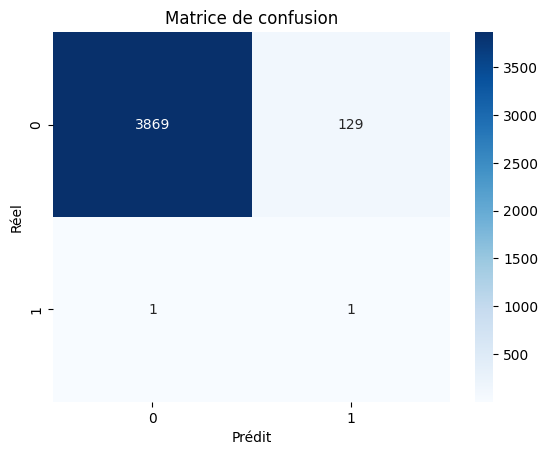

In [226]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()


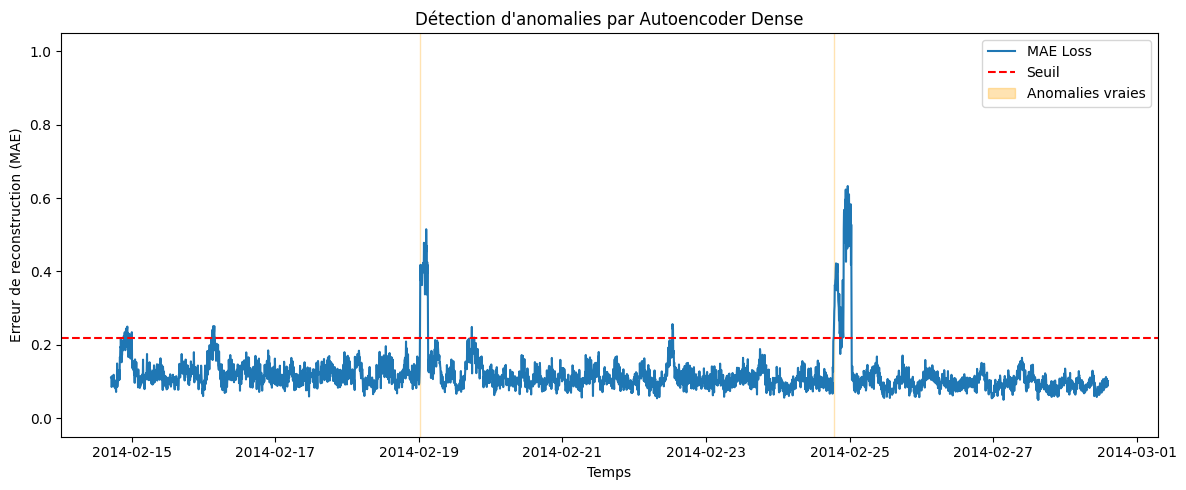

In [192]:
plt.figure(figsize=(12, 5))
plt.plot(sequence_timestamps, train_mae_loss3, label='MAE Loss')
plt.axhline(0.22, color='red', linestyle='--', label='Seuil')
plt.fill_between(sequence_timestamps, 0, 1, where=true_labels==1, color='orange', alpha=0.3, transform=plt.gca().get_xaxis_transform(), label='Anomalies vraies')
plt.legend()
plt.xlabel("Temps")
plt.ylabel("Erreur de reconstruction (MAE)")
plt.title("Détection d'anomalies par Autoencoder Dense")
plt.tight_layout()
plt.show()


### All the results and graphs are provided above. (Note we do not need to provide accuracy in a reconstruction task) We can find that the Conv1D and dense modes autoencoder work fairly well in this test. They can reconstruct the original dataset based on the 'normal behavior' and find the anomalies.